In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from unidecode import unidecode


In [2]:

def remove_special_characters(input_string):
    return unidecode(input_string)

In [3]:
dfPasses = pd.read_csv('updatedPassesPercent.csv')
teamWinsdf = pd.read_csv('team_wins2.csv')

dfPlayerData = pd.read_csv('playerData.csv')
dfPlayerData['Player'] = dfPlayerData['Player'].apply(remove_special_characters)

dfTouches = pd.read_csv('touchesData.csv')
dfTouches.rename(columns={'PLAYER\t': 'Player'}, inplace=True)
dfTouches['Player'] = dfTouches['Player'].apply(remove_special_characters)

dfPerGame = pd.read_csv('playerDataPerGame.csv')
dfPerGame['Player'] = dfPerGame['Player'].apply(remove_special_characters)

dfPerGame.rename(columns={'PTS': 'ppg'}, inplace=True)
dfPerGame.rename(columns={'FGA': 'fga_pg'}, inplace=True)
dfPlayerDataAdvanced = pd.read_csv('playerDataAdvanced.csv')
dfPlayerDataAdvanced['Player'] = dfPlayerDataAdvanced['Player'].apply(remove_special_characters)

seasonSchedule = pd.read_csv("schedule.csv", header=None).values


teamWins = teamWinsdf.to_dict()
tempdict = dfPasses.to_dict()
playerPassesDict = dict(zip(tempdict['Team'].values(), tempdict['Wins'].values()))


In [4]:
merged_df_1 = pd.merge(dfPlayerData, dfPlayerDataAdvanced, on='Player') 
merged_df = pd.merge(merged_df_1, dfTouches, on='Player') 

merged_df = pd.merge(merged_df, dfPerGame[['Player', 'ppg']], on='Player') 
merged_df = pd.merge(merged_df, dfPerGame[['Player', 'fga_pg']], on='Player') 
merged_df = merged_df[merged_df['Player'] != 'Player']  ##Remove rows that aren't players
merged_df['Player'] = merged_df['Player'].str.replace(' ', '') #Change names to same key as dict

In [5]:
def calculate_touch_per_100_min(row):
    if float(row['MIN\t']) == 0 : return 0
    return 100*float(row['TOUCHES\t']) / float(row['MIN\t'])

def calculate_prob_shot(row):
    if float(row['Touch_per100_min']) == 0 : return 0
    return float(row['FGA']) / float(row['Touch_per100_min'])

def calculate_prob_tov(row):
    if float(row['Touch_per100_min']) == 0 : return 0
    return float(row['TOV%']) / float(row['Touch_per100_min'])
    
def getNameAsIndex(row):
    return row['Player'].replace(" ", "")



In [6]:
merged_df['Touch_per100_min'] = merged_df.apply(calculate_touch_per_100_min, axis=1)
merged_df['Prob_shot'] = merged_df.apply(calculate_prob_shot, axis=1)
merged_df['prob_tov'] = merged_df.apply(calculate_prob_tov, axis=1)
merged_df['Name_index'] = merged_df.apply(getNameAsIndex, axis=1)


In [7]:
merged_df.loc[merged_df['Player'] == 'RJBarrett', 'Tm_x'] = 'TOR'


In [8]:
# Get unique values in the 'Tm_x' column
unique_teams = merged_df['Tm_x'].unique()

# Create a dictionary to store smaller DataFrames for each team
team_dfs = {}

# Loop through each unique team
for team in unique_teams:
    # Create a smaller DataFrame for the current team
    team_df = merged_df[merged_df['Tm_x'] == team]
    
    # Store the smaller DataFrame in the dictionary with the team name as key
    team_dfs[team] = team_df

# Now team_dfs contains smaller DataFrames for each team
# You can access them using the team name as key
teamNames = np.array(list(team_dfs.keys()))


In [9]:
def getTeamInfo(Team1):
    ## Returns dataframes and passing percentages for each team, 
    ## and then a list of players who I could not find passing percentages for
    team1_df= team_dfs[Team1]
    team1_dict = {}

    playersNotFound = []

    keyNames = ['PassTo', 'PassFrom']
    
    # Loop through each row of team1_df
    for index, row in team1_df.iterrows():
        player_name = row['Player']

        # Add the playerPassesDict to Team1_dict with the player's name as key
        if player_name not in playerPassesDict.keys():
            playersNotFound.append(player_name)
        else:
            result_dict = eval(playerPassesDict[player_name])
            
            for key, value in result_dict.items():
                lines = value.split('\n')
                arr = []
                for line in lines[1:]:  # Exclude the first line which contains header
                    parts = line.split()
                    name = ' '.join(parts[1:-1])
                    number = parts[-1]
                    if number[-1] == ')' : number = number[0:-1]
                    nameparts = name.split(',')
                    stringName = nameparts[1].strip() + nameparts[0].strip()
                    
                    if number[-1] != '%': 
                        arr.append([stringName, float(number)]) 
                        
                team1_dict[player_name] = arr

    return (team1_df, team1_dict), playersNotFound

In [10]:
def find_index(arr, name):
    for i, entry in enumerate(arr):
        if entry[0] == name:
            return i
    return -1


def getMarkovChainFromDict(passingDict):
    # Step 1: Extract all unique names
    unique_names = set(passingDict.keys())
    name_idx_arr = list(set(passingDict.keys()))
        
    num_names = len(unique_names)
    markovMtx = np.zeros((num_names, num_names))
    
    for i, name1 in enumerate(name_idx_arr):
        # fill markovMtx[i] with passing percents
        for j, name2 in enumerate(name_idx_arr):
            if i != j: 

                idx = find_index(passingDict[name1], name2)
                
                if idx > -1:
                    markovMtx[i][j] = passingDict[name1][idx][1]


            
    # Step 4: Print or use the similarity matrix
    return markovMtx, name_idx_arr


In [11]:
def getPassingMatrix(a):
    team_df = a[0]
    team_dict = a[1]
    finalTeam_dict = {}
    availablePlayers = list(a[1].keys())
    for playerName in availablePlayers:
        passingPercents = team_dict[playerName] ## [ [Name1, percent1], [Name2, percent2] ... ]
        newArr = []
        totSum = 0
        for passTarget, percent in passingPercents:
            if passTarget in availablePlayers:
                newArr.append([passTarget, percent])
                totSum += percent
        for i in range(len(newArr)):
            newArr[i][1] = newArr[i][1]/totSum
            
        finalTeam_dict[playerName] = newArr

    markovMtx, name_idx_arr = getMarkovChainFromDict(finalTeam_dict)
    return markovMtx, name_idx_arr
                

    

In [12]:
def getTeamPassingMtx(team):
    a, b = getTeamInfo(team)
    return getPassingMatrix(a)

In [13]:
def getStationaryDist(team):
    a = getTeamPassingMtx(team)
    transitionMtx = a[0].T
    eigenvalues, eigenvectors = np.linalg.eig(transitionMtx)
    stationary_distribution = np.real(eigenvectors[:, 0])
    # Normalize the stationary distribution
    stationary_distribution /= stationary_distribution.sum()
    return stationary_distribution

In [14]:
def getUsgDist(team):
    a = getTeamPassingMtx(team)
    playerNames = a[1]
    totUsg =[]
    for playerName in playerNames:
        usg = float(merged_df.loc[merged_df['Name_index'] == playerName]['USG%'].values[0])
        min = float(merged_df.loc[merged_df['Name_index'] == playerName]['MP_x'].values[0])
        totUsg.append(usg * min)

    totsum = np.sum(totUsg)
    totUsg = totUsg / totsum
    return totUsg
    

In [15]:
def compareUSGvsStationaryDist(teamName):
    a = getTeamPassingMtx(teamName)
    playerNames = a[1]
    plt.xticks(np.arange(len(playerNames)), playerNames, rotation = 'vertical')  # Set the ticks and labels
    plt.plot(range(len(getUsgDist(teamName))), getUsgDist(teamName), c = 'r', label = 'USG * MIN')
    plt.plot(range(len(getUsgDist(teamName))), getStationaryDist(teamName),c = 'b', label = 'Stationary Dist')
    plt.legend()
    return getUsgDist(teamName), getStationaryDist(teamName)

In [16]:
def print_matrix_box(matrix):
    n = len(matrix)
    print("┌" + "─" * (7 * n - 1) + "┐")
    for i in range(n):
        row_str = "│"
        for j in range(n):
            row_str += f" {matrix[i][j]:.2f} │"
        print(row_str)
        if i < n - 1:
            print("├" + "─" * (7 * n - 1) + "┤")
    print("└" + "─" * (7 * n - 1) + "┘")

# print_matrix_box(markovChain)

In [17]:
a = getTeamPassingMtx('TOR')
a

(array([[0.        , 0.14446953, 0.22573363, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.12866817, 0.29119639,
         0.03160271, 0.08126411, 0.        , 0.09706546],
        [0.01900238, 0.        , 0.18289786, 0.05463183, 0.0023753 ,
         0.03562945, 0.24228029, 0.05700713, 0.06413302, 0.08551069,
         0.01187648, 0.09026128, 0.12351544, 0.03087886],
        [0.04603581, 0.16112532, 0.        , 0.        , 0.        ,
         0.02557545, 0.        , 0.02046036, 0.14578005, 0.05882353,
         0.02046036, 0.19693095, 0.1713555 , 0.15345269],
        [0.        , 0.03618421, 0.        , 0.        , 0.        ,
         0.        , 0.72039474, 0.01315789, 0.00986842, 0.        ,
         0.        , 0.        , 0.22039474, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.3997599 , 0.        ,
         0.        , 0.6002401 , 0.        , 0.        ],
        [0.        ,

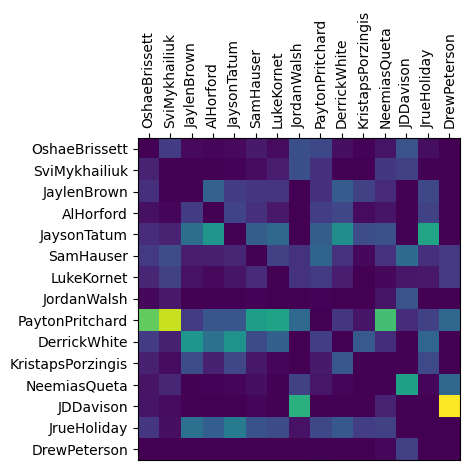

In [18]:
a = getTeamPassingMtx('BOS')
markovChain = a[0].T
plt.imshow(markovChain)

col_labels = a[1]
row_labels = a[1]
plt.xticks(np.arange(len(col_labels)), col_labels, rotation='vertical')
plt.gca().xaxis.set_ticks_position('top')  # Set ticks position to top

plt.yticks(np.arange(len(col_labels)), col_labels)

plt.tight_layout()
plt.savefig('MarkovChainIMG')

# Start Playing with games:

In [19]:
def getStartBallPos(TeamState, gamePassingMtxs):
    ## right now randomly distributed amongst all team members:
    teamSize = len(gamePassingMtxs[TeamState][1])
    touchesArr = np.zeros(teamSize)
    for ballPos_idx in range(teamSize):
        playerName = gamePassingMtxs[TeamState][1][ballPos_idx]
        touches = merged_df.loc[merged_df['Name_index'] == playerName]['TOUCHES\t'].values[0]
        touchesArr[ballPos_idx] = touches

    total_weight = sum(touchesArr)
    probabilities = [weight / total_weight for weight in touchesArr]
    sample = random.choices(range(len(touchesArr)), weights=probabilities)
    return sample[0]

In [20]:
def getStatsforPlayer(playerName):
    prob_shot = merged_df.loc[merged_df['Name_index'] == playerName]['Prob_shot']
    timePoss = merged_df.loc[merged_df['Name_index'] == playerName]['AVG SEC PER TOUCH\t']
    return prob_shot.values[0],timePoss.values[0]

In [21]:
def getPassProbability(TeamState, ballPosition, gamePassingMtxs):
    # Return a pdf of who will be passed to
    return gamePassingMtxs[TeamState][0][ballPosition]

In [22]:
def getPossTime(AvgPossesionTime):
    # return AvgPossesionTime
    #Returns the time of ball position poisson distributed at mean time
    possTime = np.random.poisson(AvgPossesionTime)
    return possTime

In [23]:
def passToLocation(passingProbArr):
    #Return the index of the player who recieves the pass
    totSum = np.sum(passingProbArr)
    if totSum != 1:
        passingProbArr = passingProbArr/totSum
    newBallLoc = np.random.choice(len(passingProbArr), p=passingProbArr)

    return newBallLoc

In [24]:
def getFTPercents(playerName):
    takeFtpct = float(merged_df.loc[merged_df['Name_index'] == playerName]['FTr'].values[0])
    Ftpct = float(merged_df.loc[merged_df['Name_index'] == playerName]['FT%'].values[0])
    if random.random() < takeFtpct :
        if random.random() < Ftpct :
            return 1
    return 0


In [25]:
def getShotPercents(playerName):
    #returns 3p attempts, 2p attempts, 3p %, 2p %
    fg3 = merged_df.loc[merged_df['Name_index'] == playerName]['3PA']
    fg2 = merged_df.loc[merged_df['Name_index'] == playerName]['2PA']
    fg3Percent = merged_df.loc[merged_df['Name_index'] == playerName]['3P%']
    fg2Percent = merged_df.loc[merged_df['Name_index'] == playerName]['2P%']
    return float(fg3.values[0]), float(fg2.values[0]), float(fg3Percent.values[0]), float(fg2Percent.values[0])

In [26]:
def takeShot(playerName, prob_shot):
    ## If not taking shot return -1
    ## If taking shot, return shot value
    
    if random.random() > prob_shot:
        # print(f' {playerName} passed - prob shot {np.round(prob_shot, 3)}')
        ##Do not shoot
        return -1

    ##If shooting
    fg3, fg2, fg3Percent, fg2Percent = getShotPercents(playerName)
    if (fg3 + fg2) == 0: 
        # print(f'{playerName} doesnt shoot')
        return -1
    take3Pter = fg3 / (fg3 + fg2)
    if random.random() < take3Pter:
        ##Take a 3
        if random.random() < fg3Percent:
            ##Make a 3
            # print(f' {playerName} made 3')
            return 3 + getFTPercents(playerName)
        else:   
            ##Miss
            # print(f' {playerName} missed')
            return 0 + getFTPercents(playerName)
    else:
        ##Take a 2
        if random.random() < fg2Percent:
            ##Make a 2
            # print(f' {playerName} made 2')
            return 2 + getFTPercents(playerName)
        else:
            ##Miss
            # print(f' {playerName} missed')
            return 0 + getFTPercents(playerName)

In [27]:
def playGame(team1, team2):
    team1Passing = getTeamPassingMtx(team1)
    team2Passing = getTeamPassingMtx(team2)
    gamePassingMtxs = (team1Passing, team2Passing)
    
    
    team0size = len(gamePassingMtxs[0][1])
    team1size = len(gamePassingMtxs[1][1])
    teamSizes = (team0size, team1size)
    
    teamScores = [0,0]
    
    gameTimeMax = 48 * 60
    gameTime = 0
    shotClockTime = 0

    TeamState = random.randint(0,1)
    ballPosition = getStartBallPos(TeamState, gamePassingMtxs)
    while gameTime < gameTimeMax:
        TeamState, ballPosition, teamScores, gameTime, shotClockTime = singlePlayerPossesion(TeamState, ballPosition, teamScores, gameTime, gamePassingMtxs, shotClockTime)
    return teamScores

In [28]:
def turnoverBall(playerName):
    tovpct = float(merged_df.loc[merged_df['Name_index'] == playerName]['prob_tov'].values[0])
    if random.random() < tovpct:
        # print(f' {playerName} TOV')
        return True
    return False

In [29]:
def singlePlayerPossesion(TeamState, ballPosition, teamScores, gameTime, gamePassingMtxs, shotClockTime):
    playerName = gamePassingMtxs[TeamState][1][ballPosition]
    prob_shot, avgTime =  getStatsforPlayer(playerName)

    possTime = getPossTime(avgTime)
    gameTime += possTime
    shotClockTime += possTime
    
    if shotClockTime + possTime > 24: 
        prob_shot = 1 #Shot clock - doesn't seem to do anything
        # print('shot clock')
    shotVal = takeShot(playerName, prob_shot)

    tov = turnoverBall(playerName)
    if tov: 
        TeamState = (TeamState + 1)%2
        ballPosition = getStartBallPos(TeamState, gamePassingMtxs)
        shotClockTime = 0
    
    if shotVal > -1:
        ##Shooting
        teamScores[TeamState] += shotVal
        TeamState = (TeamState + 1)%2
        ballPosition = getStartBallPos(TeamState, gamePassingMtxs)
        shotClockTime = 0
        # if shotVal > 0: print(f'{playerName} scores {shotVal} points at {np.round(gameTime/60)} Minutes!')
    else:
        ##Passing
        ballPosition = passToLocation(getPassProbability(TeamState, ballPosition, gamePassingMtxs))

    return TeamState, ballPosition, teamScores, gameTime, shotClockTime
        
        
    

In [30]:
def singlePlayerPossesionGetPts(TeamState, ballPosition, teamScores, gameTime, gamePassingMtxs, shotClockTime, playerStats):
    playerName = gamePassingMtxs[TeamState][1][ballPosition]
    prob_shot, avgTime =  getStatsforPlayer(playerName)

    possTime = getPossTime(avgTime)
    gameTime += possTime
    shotClockTime += possTime

    if shotClockTime + possTime > 24: 
        prob_shot = 1 
    shotVal = takeShot(playerName, prob_shot)

    tov = turnoverBall(playerName)
    if tov: 
        TeamState = (TeamState + 1)%2
        ballPosition = getStartBallPos(TeamState, gamePassingMtxs)
        shotClockTime = 0
    
    if shotVal > -1:
        ##Shooting
        teamScores[TeamState] += shotVal
        TeamState = (TeamState + 1)%2
        ballPosition = getStartBallPos(TeamState, gamePassingMtxs)
        shotClockTime = 0
        playerStats[0][TeamState][ballPosition] += shotVal
        playerStats[1][TeamState][ballPosition] += 1
        # if shotVal > 0: print(f'{playerName} scores {shotVal} points at {np.round(gameTime/60)} Minutes!')
    else:
        ##Passing
        ballPosition = passToLocation(getPassProbability(TeamState, ballPosition, gamePassingMtxs))

    return TeamState, ballPosition, teamScores, gameTime, shotClockTime, playerStats
        
        
    
def playGameGetPlayerPtsGetPts(team1, team2):
    team1Passing = getTeamPassingMtx(team1)
    team2Passing = getTeamPassingMtx(team2)
    gamePassingMtxs = (team1Passing, team2Passing)
    playerNames = (team1Passing[1], team2Passing[1])
    
    team0size = len(gamePassingMtxs[0][1])
    team1size = len(gamePassingMtxs[1][1])
    teamSizes = (team0size, team1size)

    playerPts = [np.zeros(team0size), np.zeros(team1size)]
    playerfga = [np.zeros(team0size), np.zeros(team1size)]

    playerStats = [playerPts, playerfga]
    
    teamScores = [0,0]
    
    gameTimeMax = 48 * 60
    gameTime = 0
    shotClockTime = 0

    TeamState = random.randint(0,1)
    ballPosition = getStartBallPos(TeamState, gamePassingMtxs)
    while gameTime < gameTimeMax:

        TeamState, ballPosition, teamScores, gameTime, shotClockTime, playerStats = singlePlayerPossesionGetPts(TeamState, ballPosition, teamScores, gameTime, gamePassingMtxs, shotClockTime, playerStats)
    return teamScores, playerStats, playerNames

In [31]:
def runSeries(team1, team2):
    team1wins = 0
    team2wins = 0
    for _ in range(7):
        g = playGame(team1, team2)
        if g[0] > g[1] :
            team1wins +=1
            print(f' {team1} Wins')
        else:
            team2wins +=1
            print(f'{team2} Wins')
    
    if team1wins > team2wins:
        print(f' {team1} Wins the series')
        return team1
    else:
        print(f' {team2} Wins the series')
        return team2

def simSeries(team1, team2):
    team1wins = 0
    team2wins = 0
    for _ in range(7):
        g = playGame(team1, team2)
        if g[0] > g[1] :
            team1wins +=1
        else:
            team2wins +=1
    
    if team1wins > team2wins:
        print(f' {team1} Wins the series')
        return team1
    else:
        print(f' {team2} Wins the series')
        return team2

# Play Around:

In [32]:
def rms_similarity(arr1, arr2):
    squared_diff = np.square(np.array(arr1) - np.array(arr2))
    mean_squared_diff = np.mean(squared_diff)
    rms_similarity = np.sqrt(mean_squared_diff)
    return rms_similarity

In [33]:
getStationaryDist('BOS')

array([0.03115482, 0.01717744, 0.09345723, 0.07659781, 0.16707585,
       0.07024512, 0.03882636, 0.0031469 , 0.12841531, 0.14985325,
       0.07854644, 0.01313867, 0.00421179, 0.12721747, 0.00093555])

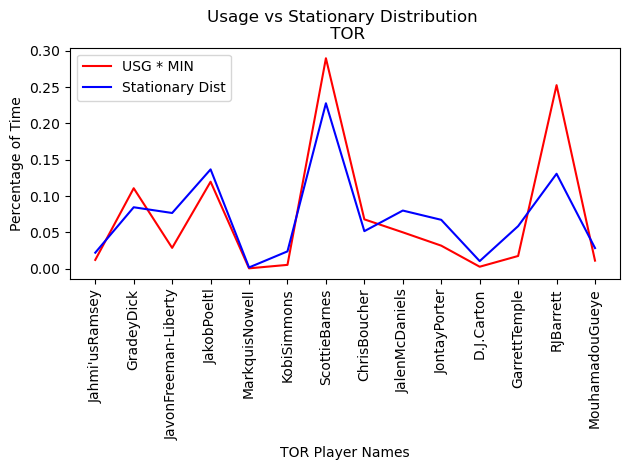

In [34]:
teamName = "TOR"
compareUSGvsStationaryDist(teamName)
plt.xlabel(f'{teamName} Player Names')
plt.ylabel('Percentage of Time')
plt.title(f'Usage vs Stationary Distribution \n {teamName}')

plt.tight_layout()  # Adjust figure layout

plt.savefig(f'StatDist{teamName}')

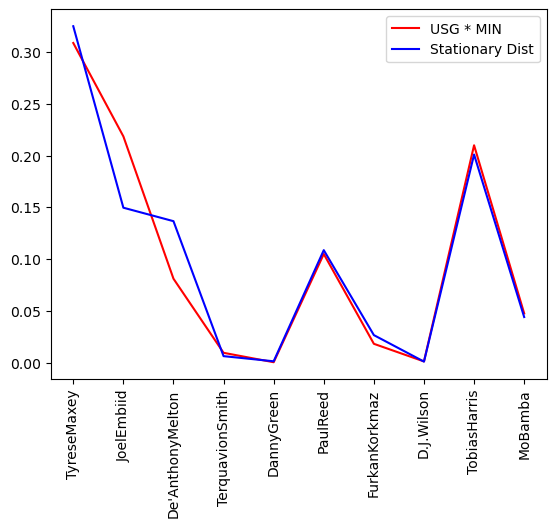

In [35]:
usg, stationary = compareUSGvsStationaryDist('PHI')
plt.show()
   
    

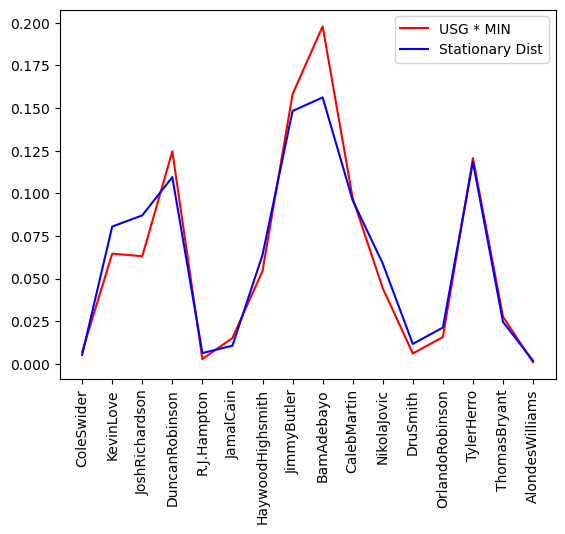

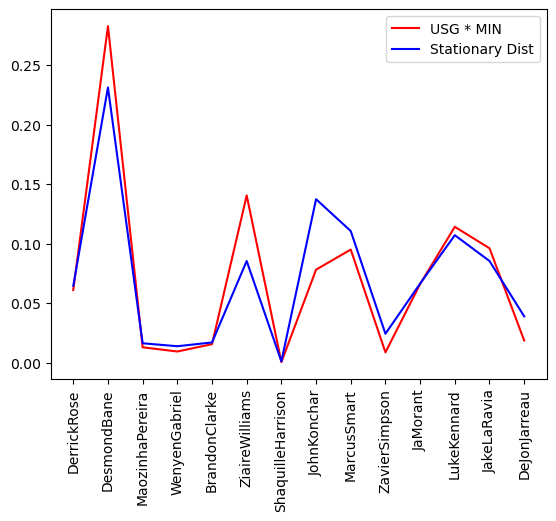

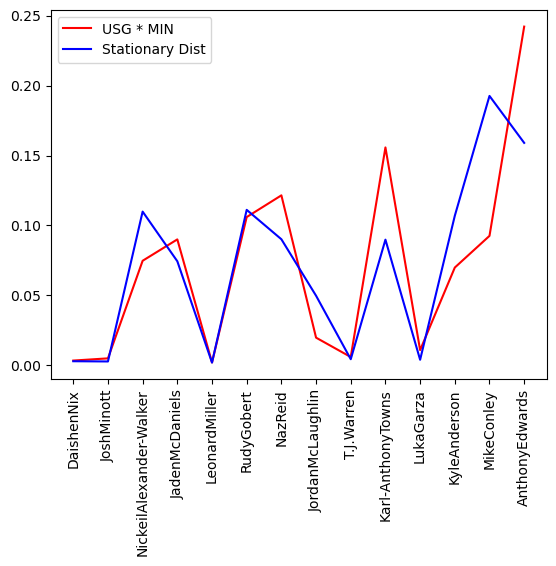

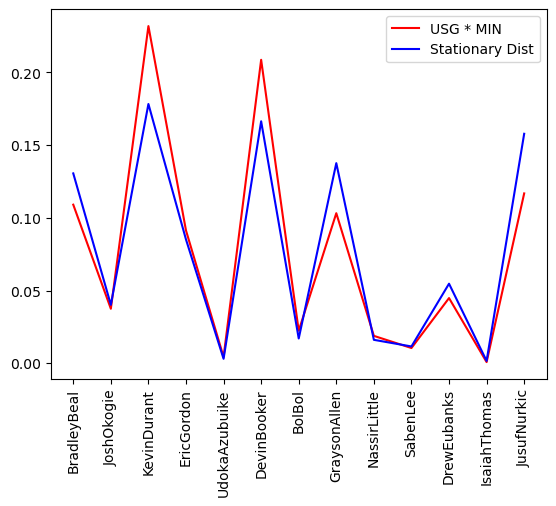

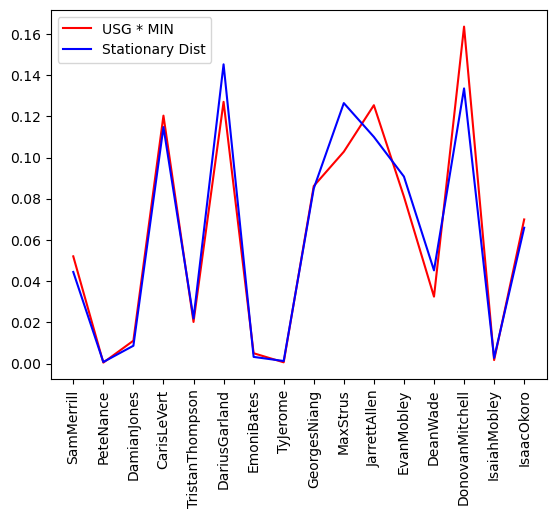

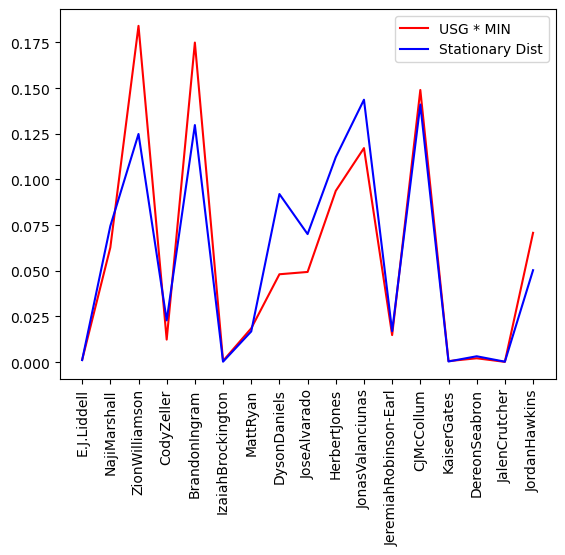

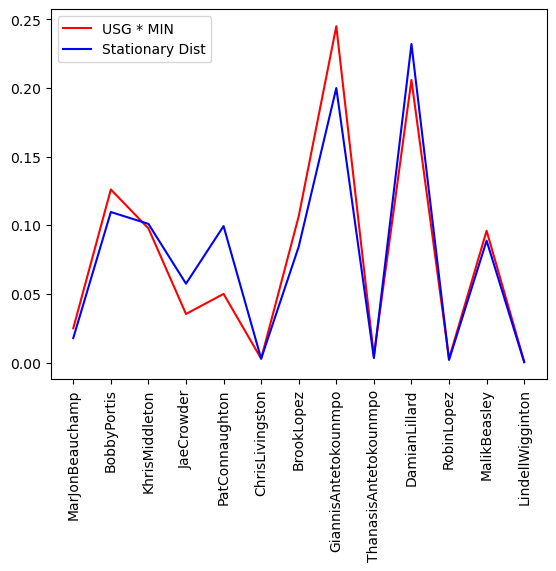

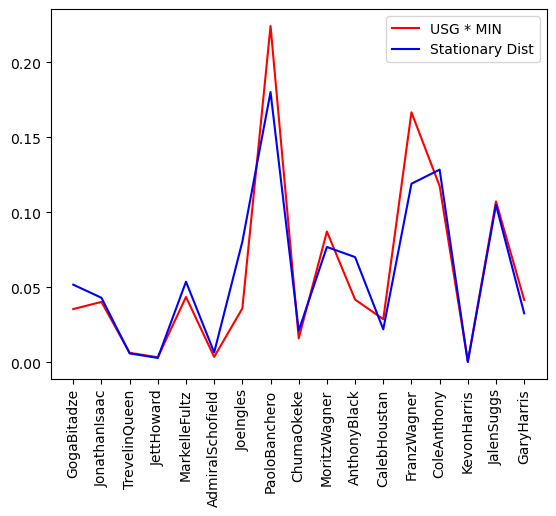

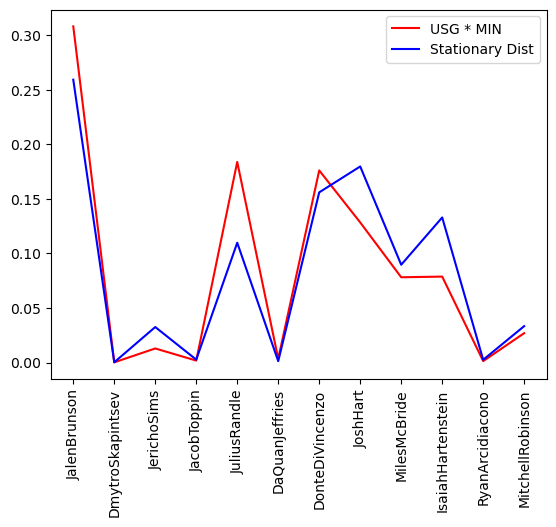

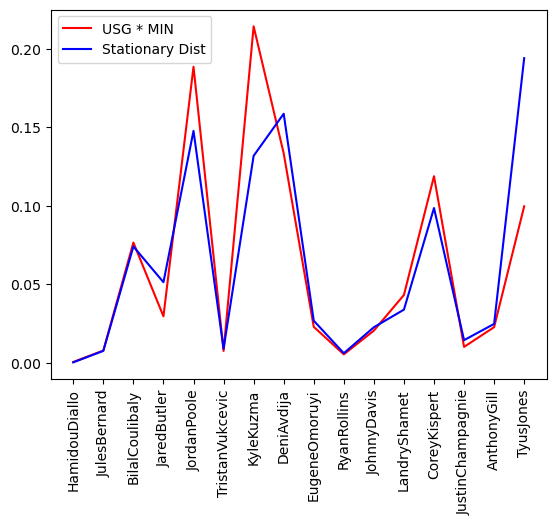

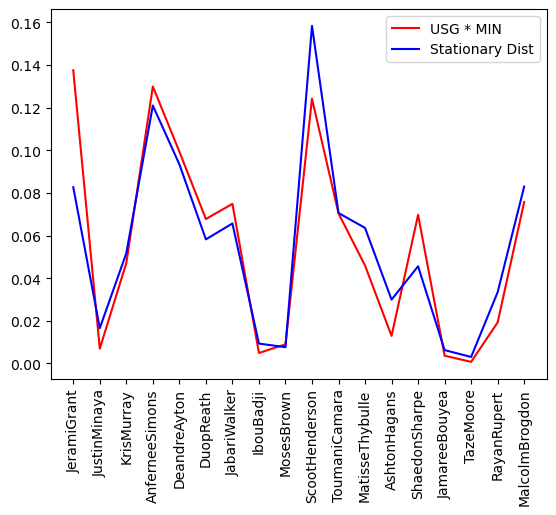

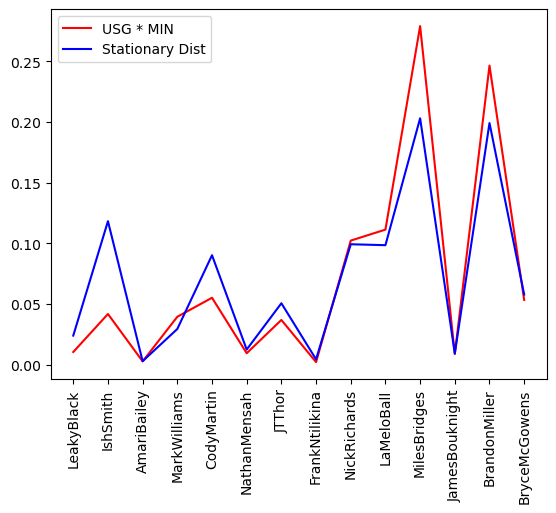

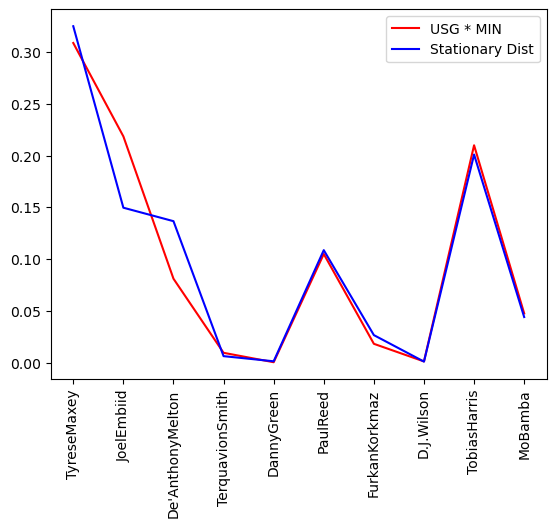

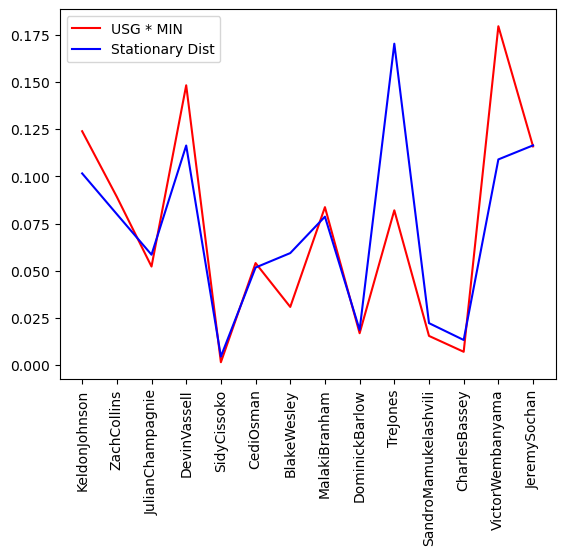

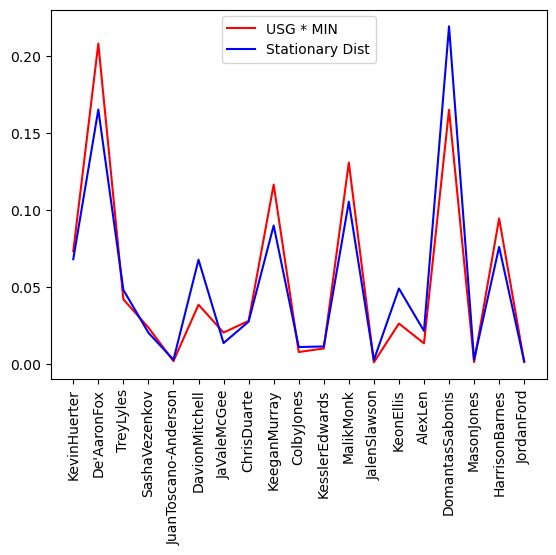

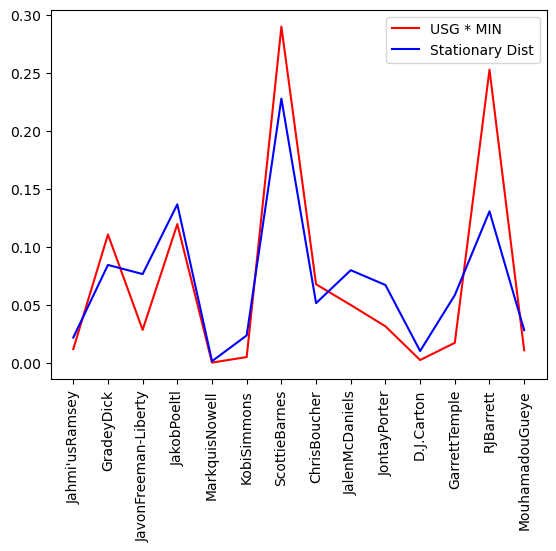

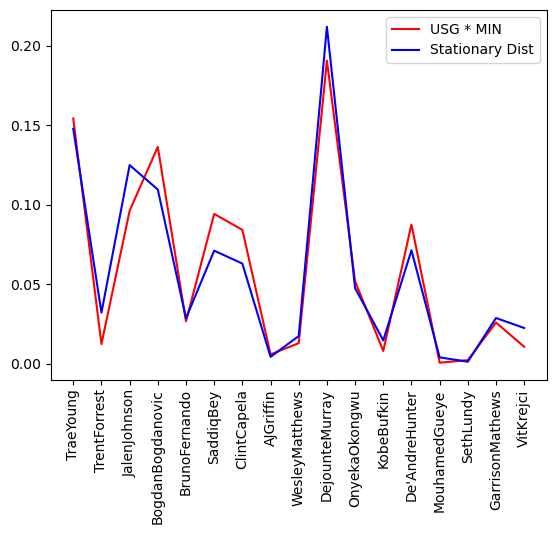

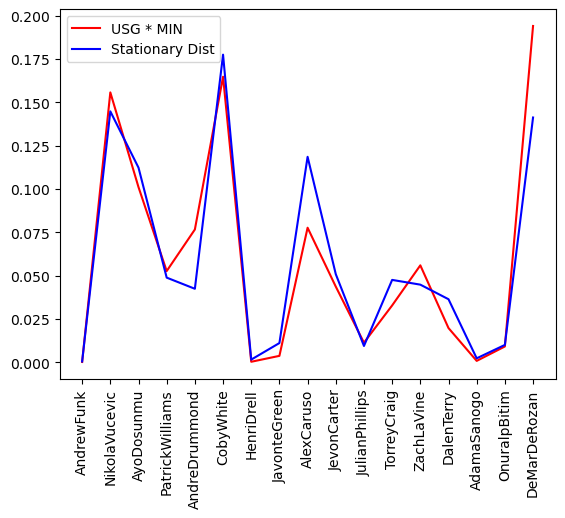

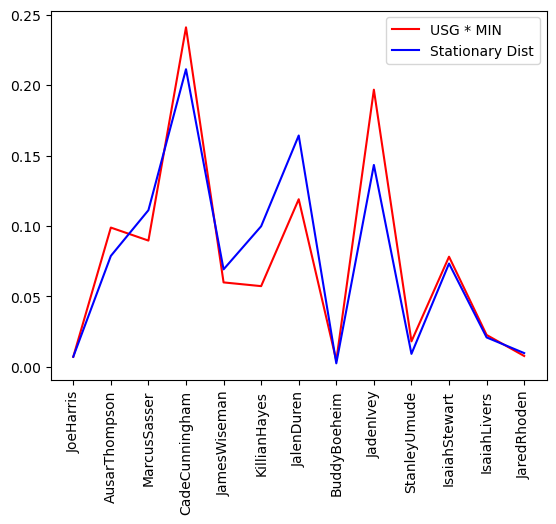

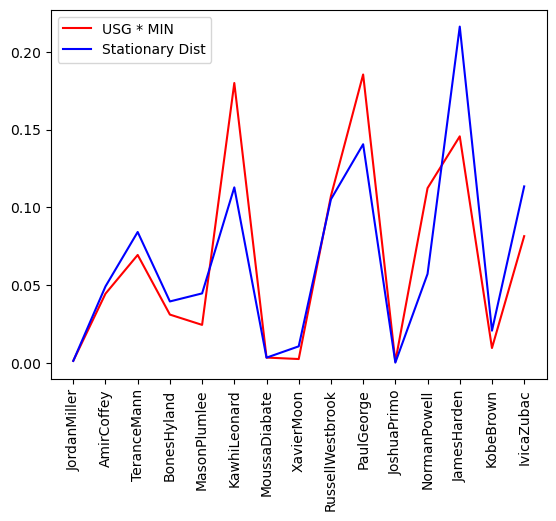

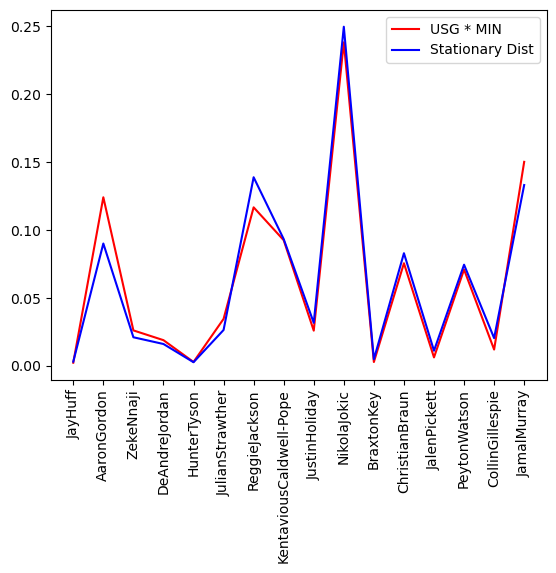

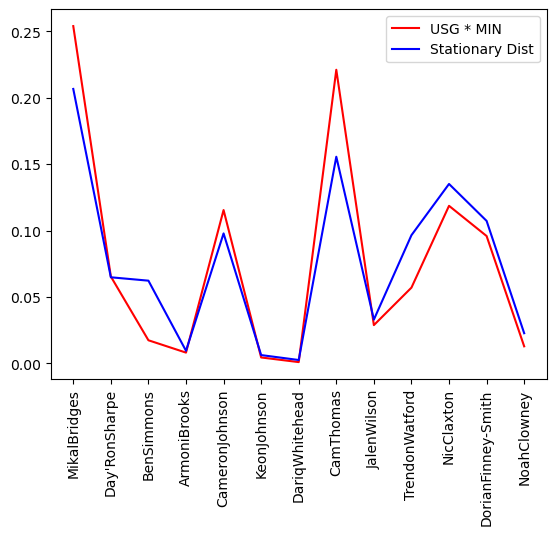

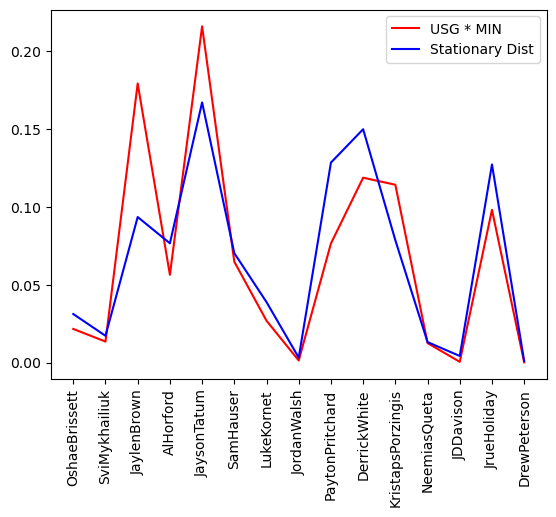

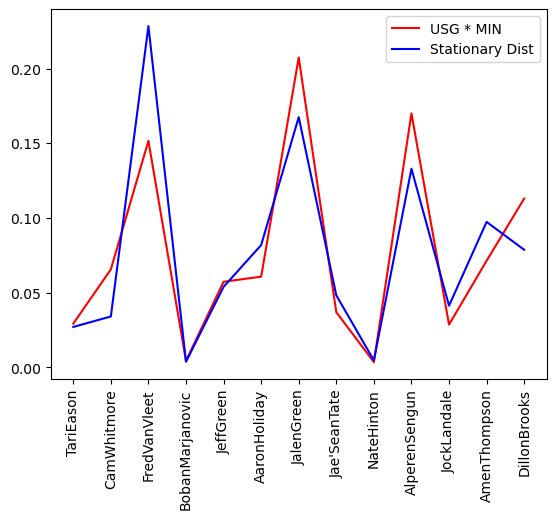

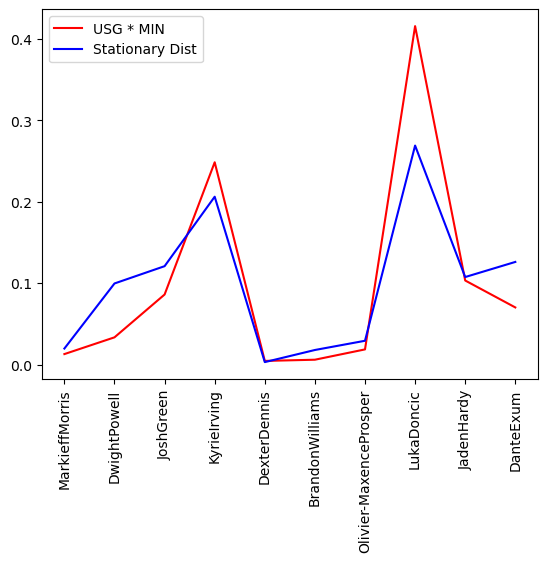

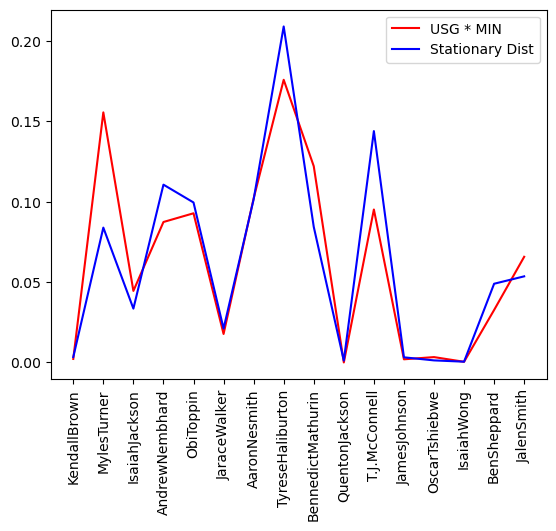

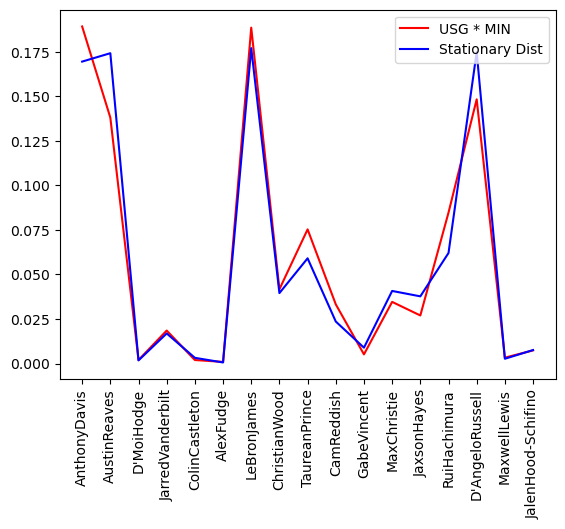

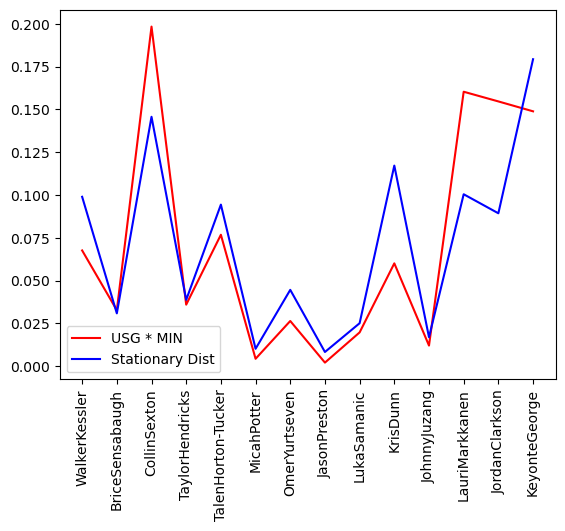

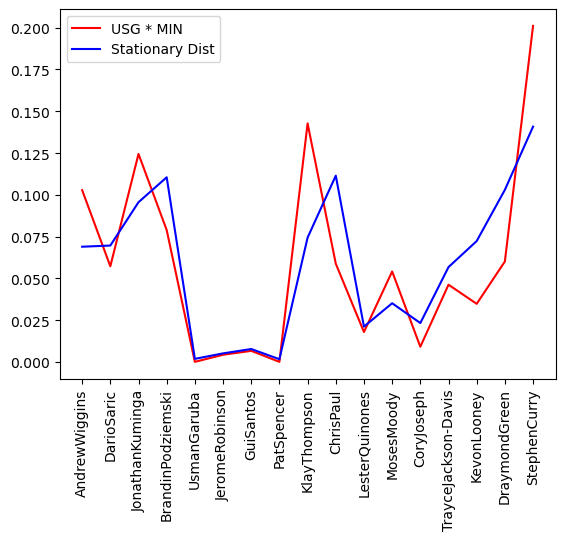

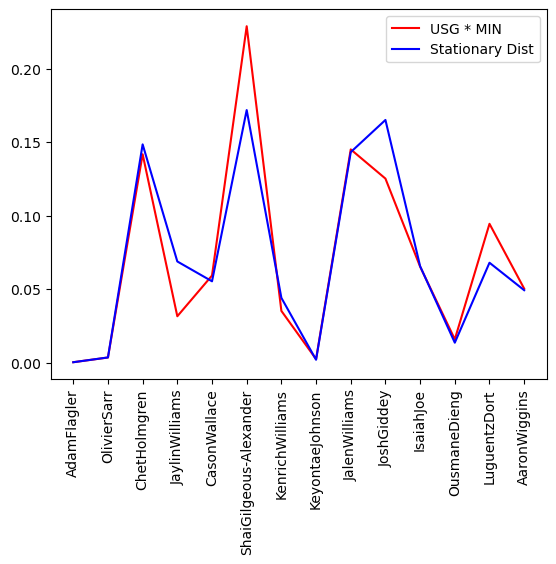

In [36]:
rms = []
for team in teamNames[1:]:
    plt.subplot()
    # print(team)
    usg, stationary = compareUSGvsStationaryDist(team)
    plt.show()
    rms.append(rms_similarity(usg, stationary))
    

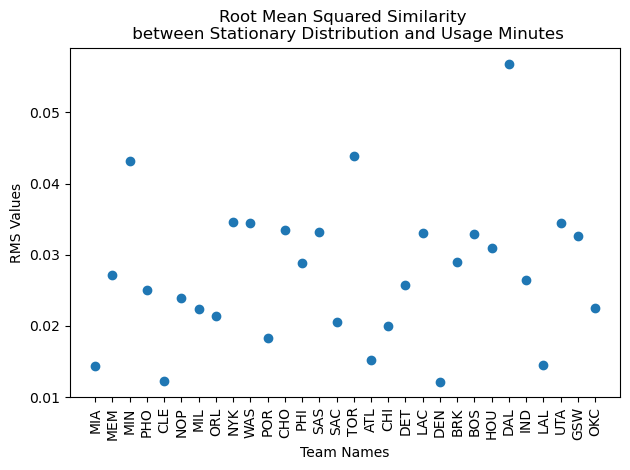

In [37]:

plt.scatter(range(len(rms)),rms)
a=plt.xticks(range(len(teamNames)-1), teamNames[1:], rotation='vertical')
plt.xlabel('Team Names')
plt.ylabel('RMS Values')
plt.title('Root Mean Squared Similarity \n between Stationary Distribution and Usage Minutes')
plt.tight_layout()  # Adjust figure layout

plt.savefig('rmsPlot')


In [38]:
teamNames

array(['TOT', 'MIA', 'MEM', 'MIN', 'PHO', 'CLE', 'NOP', 'MIL', 'ORL',
       'NYK', 'WAS', 'POR', 'CHO', 'PHI', 'SAS', 'SAC', 'TOR', 'ATL',
       'CHI', 'DET', 'LAC', 'DEN', 'BRK', 'BOS', 'HOU', 'DAL', 'IND',
       'LAL', 'UTA', 'GSW', 'OKC'], dtype='<U3')

In [39]:
def simPlayoffs():
    playoffTeams = ['OKC', 'NOP', 'LAC', 'DAL', 'MIN', 'PHO', 'DEN', 'LAL', 'BOS', 'MIA', 'CLE', 'ORL', 'MIL', 'IND', 'NYK', 'PHI']
    round2Teams = []
    round3Teams = []
    finalTeams = []
    i = 0
    while i < len(playoffTeams):
        round2Teams.append(simSeries(playoffTeams[i], playoffTeams[i+1]))
        i = i + 2
        
    i = 0
    while i < len(round2Teams):
        round3Teams.append(simSeries(round2Teams[i], round2Teams[i+1]))
        i = i + 2
    
    i = 0
    while i < len(round3Teams):
        finalTeams.append(simSeries(round3Teams[i], round3Teams[i+1]))
        i = i + 2
    
    return runSeries(finalTeams[0], finalTeams[1])

In [40]:
runGames('BOS', 'DET', 1)

NameError: name 'runGames' is not defined

In [41]:
def runGames(team1, team2, Ngames):

    score, playerStats_0, playerNames = playGameGetPlayerPtsGetPts(team1, team2)       
    team1Score = score[0]
    team2Score = score[1]
    
    for _ in range(Ngames - 1):
        score, playerStats, _ = playGameGetPlayerPtsGetPts(team1, team2)       
        team1Score += score[0]
        team2Score += score[1]
        playerStats_0[0][0] += playerStats[0][0] 
        playerStats_0[0][1] += playerStats[0][1] 
        playerStats_0[1][0] += playerStats[1][0]
        playerStats_0[1][1] += playerStats[1][1]

    return(team1Score/Ngames, team2Score/Ngames), playerStats_0, playerNames 

In [40]:
runGames('BOS', 'TOR', 4)

((120.25, 109.5),
 [[array([ 17.,   8.,  17.,  40.,  39.,  16.,  30.,   8.,  60.,  10.,  11.,
            7., 107.,  50.,  18.]),
   array([ 21.,  15.,  23.,  12., 101.,  31.,  32.,  22.,  66.,  49.,   7.,
           83.,  13.,   6.])],
  [array([15.,  6., 14., 29., 25., 21., 23.,  6., 43., 11.,  9.,  9., 62.,
          35.,  9.]),
   array([12., 16., 25., 20., 74., 24., 25., 17., 45., 31.,  5., 56.,  8.,
           3.])]],
 (['LukeKornet',
   'JDDavison',
   'SamHauser',
   'KristapsPorzingis',
   'AlHorford',
   'PaytonPritchard',
   'JrueHoliday',
   'DrewPeterson',
   'DerrickWhite',
   'OshaeBrissett',
   'JordanWalsh',
   'NeemiasQueta',
   'JaysonTatum',
   'JaylenBrown',
   'SviMykhailiuk'],
  ['GarrettTemple',
   'GradeyDick',
   'JavonFreeman-Liberty',
   'JontayPorter',
   'ScottieBarnes',
   "Jahmi'usRamsey",
   'KobiSimmons',
   'ChrisBoucher',
   'JakobPoeltl',
   'MouhamadouGueye',
   'D.J.Carton',
   'RJBarrett',
   'JalenMcDaniels',
   'MarkquisNowell']))

In [176]:
Ngames = 30
gameScores, playerStats, playerNames = runGames('DAL', 'DEN', Ngames)

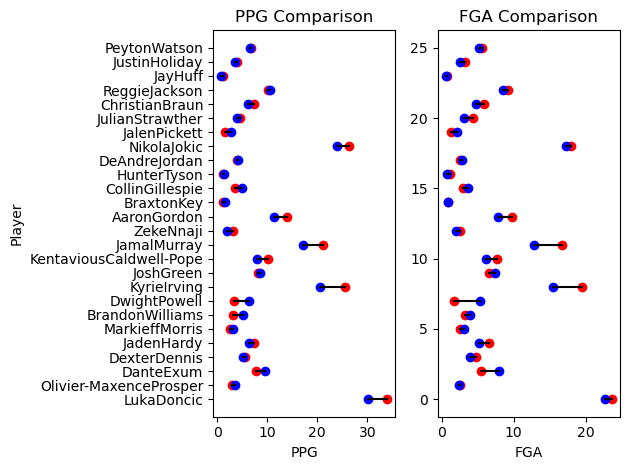

(108.93333333333334, 98.56666666666666)


In [177]:
teamppgs = []
teamfg_pg = []



for teamNum in [0,1]:
    
    for i in range(len(playerNames[teamNum])):
        fga_pg =  float(merged_df.loc[merged_df['Name_index'] == playerNames[teamNum][i]]['fga_pg'].values[0])
        ppg =  float(merged_df.loc[merged_df['Name_index'] == playerNames[teamNum][i]]['ppg'].values[0])
    
        teamppgs.append( (ppg, playerStats[0][teamNum][i]/Ngames))
        teamfg_pg.append((fga_pg, playerStats[1][teamNum][i]/Ngames))
        # print(f'{c[teamNum][i]} scores {ppg} ppg in the nba and {b[teamNum][i]/30} ppg in our sim')


fig, (ax1, ax2) = plt.subplots(1,2)
for i in range(len(teamppgs)):
    # PPG
    ax1.scatter( teamppgs[i][0],i, c='r')
    ax1.scatter(teamppgs[i][1],i, c='b')
    ax1.plot( [teamppgs[i][0], teamppgs[i][1]], [i, i],c='black')
    # FGA
    ax2.scatter( teamfg_pg[i][0],i, c='r')
    ax2.scatter(teamfg_pg[i][1],i, c='b')
    ax2.plot( [teamfg_pg[i][0], teamfg_pg[i][1]], [i, i],c='black')
    
# Set xticks and xticklabels to align with the scatter points
players = playerNames[0] + playerNames[1]
ax1.set_yticks(range(len(players)), players)

# Adding labels and title
ax1.set_xlabel('PPG')
ax1.set_ylabel('Player')
ax1.set_title('PPG Comparison')
ax2.set_xlabel('FGA')
ax2.set_title('FGA Comparison')

plt.tight_layout()
plt.savefig(f'ppgComparisonLACDEN')

# Show plot
plt.show()

print(gameScores)

In [42]:
def singlePlayerPossesionPrint(TeamState, ballPosition, teamScores, gameTime, gamePassingMtxs, shotClockTime):
    playerName = gamePassingMtxs[TeamState][1][ballPosition]
    prob_shot, avgTime =  getStatsforPlayer(playerName)

    possTime = getPossTime(avgTime)
    gameTime += possTime
    shotClockTime += possTime
    
    if shotClockTime + possTime > 24: 
        prob_shot = 1 #Shot clock - doesn't seem to do anything
        # print('shot clock')
    shotVal = takeShot(playerName, prob_shot)

    tov = turnoverBall(playerName)
    if tov: 
        TeamState = (TeamState + 1)%2
        ballPosition = getStartBallPos(TeamState, gamePassingMtxs)
        shotClockTime = 0
    
    if shotVal > -1:
        ##Shooting
        teamScores[TeamState] += shotVal
        TeamState = (TeamState + 1)%2
        ballPosition = getStartBallPos(TeamState, gamePassingMtxs)
        shotClockTime = 0
        if shotVal > 0: print(f'{playerName} scores {shotVal} points at {np.round(gameTime/60)} Minutes!')
    else:
        ##Passing
        ballPosition = passToLocation(getPassProbability(TeamState, ballPosition, gamePassingMtxs))

    return TeamState, ballPosition, teamScores, gameTime, shotClockTime
        
        
    

def playGamePrint(team1, team2):
    team1Passing = getTeamPassingMtx(team1)
    team2Passing = getTeamPassingMtx(team2)
    gamePassingMtxs = (team1Passing, team2Passing)
    
    
    team0size = len(gamePassingMtxs[0][1])
    team1size = len(gamePassingMtxs[1][1])
    teamSizes = (team0size, team1size)
    
    teamScores = [0,0]
    
    gameTimeMax = 48 * 60
    gameTime = 0
    shotClockTime = 0

    TeamState = random.randint(0,1)
    ballPosition = getStartBallPos(TeamState, gamePassingMtxs)
    while gameTime < gameTimeMax:
        TeamState, ballPosition, teamScores, gameTime, shotClockTime = singlePlayerPossesionPrint(TeamState, ballPosition, teamScores, gameTime, gamePassingMtxs, shotClockTime)
    return teamScores

In [43]:
def simPlayoffs():
    playoffTeams = ['OKC', 'NOP', 'LAC', 'DAL', 'MIN', 'PHO', 'DEN', 'LAL', 'BOS', 'MIA', 'CLE', 'ORL', 'MIL', 'IND', 'NYK', 'PHI']
    round2Teams = []
    round3Teams = []
    finalTeams = []
    i = 0
    while i < len(playoffTeams):
        round2Teams.append(simSeries(playoffTeams[i], playoffTeams[i+1]))
        i = i + 2
        
    i = 0
    print('ROUND 2:')
    while i < len(round2Teams):
        round3Teams.append(simSeries(round2Teams[i], round2Teams[i+1]))
        i = i + 2
        
    print('Conference Championships:')
    i = 0
    while i < len(round3Teams):
        finalTeams.append(simSeries(round3Teams[i], round3Teams[i+1]))
        i = i + 2
        
    print('NBA FINALS:')

    return runSeries(finalTeams[0], finalTeams[1])

In [44]:
##SEASON SIMULATION ##
import concurrent.futures
import threading

def simSeasonGame(game):
    if game[0] == "BKN": game[0] = "BRK" 
    if game[1] == "BKN": game[1] = "BRK" 
    if game[0] == "CHA": game[0] = "CHO" 
    if game[1] == "CHA": game[1] = "CHO" 
    if game[0] == "PHX": game[0] = "PHO" 
    if game[1] == "PHX": game[1] = "PHO" 
    return playGame(game[0], game[1])

def process_game(game):
    global teamWins
    score = simSeasonGame(game)
    if score[0] > score[1]:
        with lock:
            teamWins[game[0]] += 1
    else:
        with lock:
            teamWins[game[1]] += 1

def simSeason():
    global teamWins  # Declare teamWins as global

    gamesInSeason = seasonSchedule[1:]

    num_threads = 7
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [executor.submit(process_game, game) for game in gamesInSeason]
        concurrent.futures.wait(futures)
            


global teamWins
global lock
lock = threading.Lock()

teamWins = {}
for team in teamNames:
    teamWins[team] = 0

numSeasons = 4
numruns = int(numSeasons/2)
for _ in range(numruns):
    simSeason()

KeyboardInterrupt: 

In [ ]:
tempWins = teamWins

In [55]:
sum = 0
for a in teamWins.values():
    sum += a/82

In [50]:
for i in tempWins:
    tempWins[i] = tempWins[i]/4
tempWins

{'TOT': 0.0,
 'MIA': 44.5,
 'MEM': 25.25,
 'MIN': 42.25,
 'PHO': 44.5,
 'CLE': 39.5,
 'NOP': 41.5,
 'MIL': 60.0,
 'ORL': 33.75,
 'NYK': 46.25,
 'WAS': 32.5,
 'POR': 21.75,
 'CHO': 19.25,
 'PHI': 63.0,
 'SAS': 28.25,
 'SAC': 45.0,
 'TOR': 21.0,
 'ATL': 49.0,
 'CHI': 40.75,
 'DET': 23.0,
 'LAC': 53.5,
 'DEN': 43.75,
 'BRK': 38.5,
 'BOS': 53.5,
 'HOU': 38.75,
 'DAL': 61.0,
 'IND': 48.75,
 'LAL': 44.0,
 'UTA': 32.5,
 'GSW': 37.25,
 'OKC': 57.5}

In [51]:
import csv

csv_file = "team_wins2.csv"

# Write the dictionary to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Team", "Wins"])  # Write header
    for team, wins in tempWins.items():
        writer.writerow([team, wins])

In [52]:
updated_team_wins = tempWins

In [53]:
teams_wins_real_dict = {
    "BOS": 64, "NYK": 50, "PHI": 47, "BRK": 32, "TOR": 25,  # Atlantic
    "MIL": 49, "CLE": 48, "IND": 47, "CHI": 39, "DET": 14,  # Central
    "ORL": 47, "MIA": 46, "ATL": 36, "CHO": 21, "WAS": 15,  # Southeast
    "OKC": 57, "DEN": 57, "MIN": 56, "UTA": 31, "POR": 21,  # Northwest
    "LAC": 51, "PHO": 49, "LAL": 47, "SAC": 46, "GSW": 46,  # Pacific
    "DAL": 50, "NOP": 49, "HOU": 41, "MEM": 27, "SAS": 22  # Southwest
}


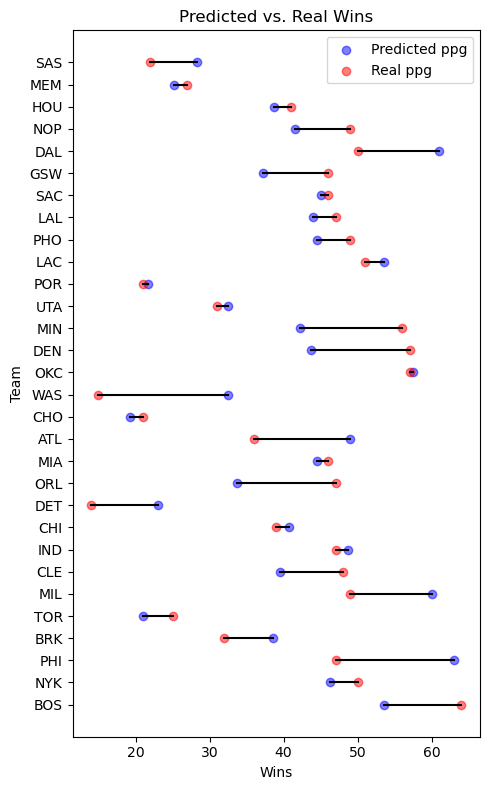

Average Win Differential: 6.6


In [63]:
# Extract team names and wins from dictionaries
teams = list(teams_wins_real_dict.keys())
updated_wins = []
real_wins = []
for team in teams:
    updated_wins.append(updated_team_wins[team])
    real_wins.append(teams_wins_real_dict[team])

updated_wins = np.array(updated_wins)
real_wins  = np.array(real_wins)
# Create a figure with two subplots
fig, ax1 = plt.subplots(1, 1, figsize=(5, 8))

# Plotting updated wins
ax1.scatter(updated_wins,teams, color='b', alpha=0.5,label='Predicted Wins')

# Plotting real wins
ax1.scatter(real_wins,teams,  color='r', alpha=0.5, label='Real Wins')
for i in range(len(teams)):
    ax1.plot( [updated_wins[i], real_wins[i]], [i, i],c='black')



# Calculate RMS similarity between updated and real wins
rms = np.mean(abs(updated_wins - real_wins))

# Adding titles and labels
ax1.set_title('Predicted vs. Real Wins')
ax1.set_xlabel('Wins')
ax1.set_ylabel('Team')
ax1.legend()

# Display the plot
plt.tight_layout()
plt.savefig("seasonSim")
plt.show()

# Print RMS similarity
print("Average Win Differential:", rms)

# CLASS DEMO:

In [52]:
playGame('NYK', 'PHI')

[113, 127]

In [53]:
playGamePrint('NYK', 'PHI')

TobiasHarris scores 2 points at 0.0 Minutes!
JuliusRandle scores 2 points at 1.0 Minutes!
TyreseMaxey scores 2 points at 1.0 Minutes!
JalenBrunson scores 3 points at 2.0 Minutes!
JalenBrunson scores 1 points at 3.0 Minutes!
TyreseMaxey scores 2 points at 4.0 Minutes!
JalenBrunson scores 2 points at 4.0 Minutes!
IsaiahHartenstein scores 1 points at 5.0 Minutes!
TyreseMaxey scores 3 points at 5.0 Minutes!
JalenBrunson scores 2 points at 6.0 Minutes!
JoelEmbiid scores 1 points at 6.0 Minutes!
JalenBrunson scores 1 points at 6.0 Minutes!
DonteDiVincenzo scores 1 points at 7.0 Minutes!
TyreseMaxey scores 3 points at 7.0 Minutes!
JalenBrunson scores 2 points at 8.0 Minutes!
TyreseMaxey scores 2 points at 8.0 Minutes!
JoshHart scores 2 points at 9.0 Minutes!
JalenBrunson scores 4 points at 10.0 Minutes!
TobiasHarris scores 2 points at 10.0 Minutes!
JoelEmbiid scores 2 points at 10.0 Minutes!
TyreseMaxey scores 2 points at 11.0 Minutes!
MitchellRobinson scores 2 points at 11.0 Minutes!
JalenBr

[86, 103]

In [50]:
simPlayoffs()

 OKC Wins the series
 DAL Wins the series
 PHO Wins the series
 DEN Wins the series
 BOS Wins the series
 CLE Wins the series
 MIL Wins the series
 PHI Wins the series
ROUND 2:
 OKC Wins the series
 DEN Wins the series
 BOS Wins the series
 MIL Wins the series
Conference Championships:
 OKC Wins the series
 MIL Wins the series
NBA FINALS:
 OKC Wins
 OKC Wins
MIL Wins
 OKC Wins
 OKC Wins
MIL Wins
 OKC Wins
 OKC Wins the series


'OKC'